1. 编写一个类，支持读取文件，自动将train和test的数据集合并在一起，并且通过flag区分，支持指定label来自动生成y
2. 可以定义几种常用的处理方式来处理特征，例如标准化和onehotcode等
3. 自动分析变量和画图、慢慢来
4. 能够设定评价指标后，自动进行CV测试
5. 能够自动搜索最佳超参数，然后选取最好的那个
6. 支持导出结果文件
7. 支持多模型比较和融合

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection  import cross_val_score
from sklearn.model_selection import GridSearchCV
import sklearn.metrics 
import xgboost as xgb
import matplotlib.pylab as plt

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
class MLPipe:
    # type_c_or_r: c  表示分类模型，r 表示回归模型
    def __init__(self, train_file, test_file, y_col, id_col, ft_name, type_c_or_r):
        self.train_file = train_file
        self.test_file = test_file
        self.y_col = y_col
        self.id_col = id_col
        self.type_c_or_r = type_c_or_r
        self.col_is_train = 'col_is_train'
        self.mod_list = [] 
        self.rand_state = 43
        self.ft_name = ft_name  # 数据集名称 
    
    # 用来标识数据集的名字，主要用来输出结果文件名
    def set_ft_name(self, ft_name):
        self.ft_name = ft_name
        
    # 读取文件，然后合并两个文件
    def parse_file(self):
        self.src_train_df = pd.read_csv(self.train_file)
        self.src_test_df = pd.read_csv(self.test_file)
        
        self.train_df = self.src_train_df.copy()
        self.test_df = self.src_test_df.copy()
        
        # 设置test数据的y值为0，并且区分
        self.test_df[self.y_col] = 0
        self.test_df[self.col_is_train] = 0 
        self.train_df[self.col_is_train] = 1
        # 合并两个数据集，后续所有操作都在all_df中
        self.all_df = pd.concat([self.train_df, self.test_df],ignore_index=True)
        
        self.print_shape()
            
    def print_shape(self):
        print("Train Shape: %d:%d" %(self.train_df.shape))
        print("Test  Shape: %d:%d" %(self.test_df.shape))
        print("All   Shape: %d:%d" %(self.all_df.shape))
        
    def split_X_y(self):
        self.X_train = self.all_df[self.all_df[self.col_is_train] == 1]
        self.y_train = self.X_train[self.y_col]
        self.X_train = self.X_train.drop(self.y_col, axis=1)

        self.X_test = self.all_df[self.all_df[self.col_is_train] == 0]
        self.y_test = self.X_test[self.y_col]
        self.X_test = self.X_test.drop(self.y_col, axis=1)
        
    def out_res_file(self):
        y_pred =  self.mod.predict(self.X_test)
        output = pd.DataFrame({'id': self.X_test[self.id_col].astype(np.int32), self.y_col: y_pred})
        out_file = self.res_file
        print('out_res_file to %s' %out_file)
        output.to_csv(out_file, index=False)

In [39]:
class XGBC_ML(MLPipe):
    #print("MSE:",mean_squared_error(y_eval, y_pred))      
    def gen_model(self):   
        self.model_name = 'XGBC'
        self.params={
            'n_estimators':10,
            'objective': 'binary:logistic', #回归问题 reg:linear 分类问题  binary:logistic  排序 rank:pairwise
            'learning_rate': 0.1, # 学习率，默认0.3
            'max_depth':6, # 构建树的深度，越大越容易过拟合.默认6 
            'subsample':1, # 随机采样训练样本，默认1
            'min_child_weight':1, # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
            #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
            #这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
            'seed':819
            }
            #from sklearn.ensemble import XGBRegressor
        self.mod = xgb.XGBClassifier(**self.params)
        self.res_file = 'f%s_m%s_n%d_d%s.csv'  %(self.ft_name, self.model_name, 
                                                 self.mod.n_estimators,
                                                 self.mod.max_depth)
        self.early_stopping_rounds = 50
        print  self.mod 
    
    def choose_best_n_estimators(self):
        xgb_param = self.mod.get_xgb_params()
        xgtrain = xgb.DMatrix(ml.X_train, label=ml.y_train)
        #max_n_estimators = self.mod.get_params()['n_estimators']
        max_n_estimators = 1000
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=max_n_estimators,
                    nfold=5,metrics='auc', early_stopping_rounds=50, verbose_eval=1,
                    seed =819)
        ml.mod.set_params(n_estimators=cvresult.shape[0])
        print 'Set best_n_estimators:%d'%(cvresult.shape[0])
        
        # plot 
        cv_mean = cvresult.iloc[:,[0,2]]
        cv_mean.plot()
        plt.show()
        
    def mod_fit(self, mod, plot_imp=True):
        eval_set=[(self.X_train, self.y_train)]
        # 'eval_metric': 'auc', # rmse mae logloss error auc 
        mod.fit(self.X_train, self.y_train, eval_metric='auc', eval_set=eval_set)
        
        #Predict training set:
        dtrain_predictions = mod.predict(self.X_train)
        dtrain_predprob = mod.predict_proba(self.X_train)[:,1]
            
        #Print model report:
        print "\nModel Report"
        print "Accuracy : %.4g" % metrics.accuracy_score(self.y_train, dtrain_predictions)
        print "AUC Score (Train): %f" % metrics.roc_auc_score(self.y_train, dtrain_predprob)
                        
        feat_imp = pd.Series(mod.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()
        
    def mod_cv(self, cv=5):
        scores = cross_val_score(self.mod, self.X_train, self.y_train, cv=cv, scoring='r2')
        print("Mod[%s]  R2: %0.6f (+/- %0.6f)") %(self.model_name, scores.mean(), scores.std())
        
    def mod_gv(self, cv_params):
        
cv_params = {'max_depth': [2,3,4,5,6], 'min_child_weight': [1,5]}
        gv = GridSearchCV(clt, cv_params,  cv = 5, verbose=10,
                             n_jobs = 2)
optimized_GBM.fit(ml.X_train, ml.y_train)
#optimized_GBM.grid_scores_
optimized_GBM

In [40]:
ml = XGBC_ML(train_file='./Ghost/train.csv', test_file='./Ghost/test.csv', 
            y_col='type', id_col='id', ft_name='ghost', type_c_or_r='c')
ml.parse_file()
ml.split_X_y()

Train Shape: 371:7
Test  Shape: 529:7
All   Shape: 900:7


In [41]:
all_df = ml.all_df
#all_df.info()

In [42]:
ml.gen_model()
#ml.mod_fit(ml.mod)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=10, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=819, silent=True, subsample=1)


In [43]:
ml.mod_fit(ml.mod)
#ml.cv_model()

[0]	validation_0-auc:0.967377


[1]	validation_0-auc:0.977135


[2]	validation_0-auc:0.980769


[3]	validation_0-auc:0.979474


[4]	validation_0-auc:0.980483


[5]	validation_0-auc:0.980063


[6]	validation_0-auc:0.982183


[7]	validation_0-auc:0.98654


[8]	validation_0-auc:0.991975


[9]	validation_0-auc:0.992277



Model Report


NameError: global name 'metrics' is not defined

In [44]:
ml.mod_cv()

Mod[XGBC]  R2: 0.401844 (+/- 0.205405)


In [45]:
ml.out_res_file()

out_res_file to fghost_mXGBC_n10_d6.csv


[0]	train-auc:0.97248+0.0101102	test-auc:0.910318+0.0309783


[1]	train-auc:0.976608+0.00506156	test-auc:0.918933+0.0344769


[2]	train-auc:0.977064+0.00498619	test-auc:0.916679+0.0331164


[3]	train-auc:0.980262+0.00587896	test-auc:0.925209+0.0325596


[4]	train-auc:0.984278+0.00212543	test-auc:0.922957+0.0327266


[5]	train-auc:0.985255+0.00165774	test-auc:0.924358+0.0318356


[6]	train-auc:0.988458+0.00344353	test-auc:0.92639+0.0317932


[7]	train-auc:0.989997+0.00253601	test-auc:0.926167+0.030235


[8]	train-auc:0.992203+0.00145927	test-auc:0.933227+0.0362738


[9]	train-auc:0.993137+0.0013686	test-auc:0.933365+0.0358691


[10]	train-auc:0.994392+0.0014632	test-auc:0.936486+0.0354621


[11]	train-auc:0.995063+0.00140419	test-auc:0.938922+0.0343847


[12]	train-auc:0.995601+0.00162707	test-auc:0.938345+0.0351149


[13]	train-auc:0.996018+0.00153947	test-auc:0.93917+0.0358601


[14]	train-auc:0.996385+0.00132621	test-auc:0.938744+0.034447


[15]	train-auc:0.996851+0.00136722	test-auc:0.93991+0.0338432


[16]	train-auc:0.9973+0.0012028	test-auc:0.939415+0.0340648


[17]	train-auc:0.997621+0.000962982	test-auc:0.938219+0.0356745


[18]	train-auc:0.997949+0.000960042	test-auc:0.940112+0.0344587


[19]	train-auc:0.998274+0.000778029	test-auc:0.939958+0.0348611


[20]	train-auc:0.998431+0.000556594	test-auc:0.943061+0.0331747


[21]	train-auc:0.998684+0.000524774	test-auc:0.944813+0.0320975


[22]	train-auc:0.998811+0.000518565	test-auc:0.945694+0.0314998


[23]	train-auc:0.99899+0.000404874	test-auc:0.945662+0.0309246


[24]	train-auc:0.999054+0.000478154	test-auc:0.946011+0.0302842


[25]	train-auc:0.999118+0.000491797	test-auc:0.945587+0.0308038


[26]	train-auc:0.99916+0.000484776	test-auc:0.946953+0.0303398


[27]	train-auc:0.999233+0.00043384	test-auc:0.947506+0.031298


[28]	train-auc:0.999349+0.00039911	test-auc:0.946815+0.0318274


[29]	train-auc:0.999464+0.000320122	test-auc:0.948851+0.0309011


[30]	train-auc:0.999528+0.000297436	test-auc:0.947987+0.0309694


[31]	train-auc:0.999549+0.000290444	test-auc:0.94888+0.0297422


[32]	train-auc:0.999633+0.000238429	test-auc:0.949689+0.0288487


[33]	train-auc:0.999664+0.00021654	test-auc:0.949372+0.0293431


[34]	train-auc:0.999706+0.000188074	test-auc:0.95003+0.0289334


[35]	train-auc:0.999748+0.000156088	test-auc:0.949184+0.0281491


[36]	train-auc:0.999758+0.000146165	test-auc:0.949859+0.0282215


[37]	train-auc:0.99979+0.000114484	test-auc:0.949349+0.0285042


[38]	train-auc:0.9998+0.000106678	test-auc:0.949503+0.0288159


[39]	train-auc:0.999821+0.00011252	test-auc:0.949655+0.0285415


[40]	train-auc:0.999864+9.05547e-05	test-auc:0.949156+0.0278611


[41]	train-auc:0.999885+8.32284e-05	test-auc:0.94899+0.0280022


[42]	train-auc:0.999895+7.35429e-05	test-auc:0.949484+0.0276059


[43]	train-auc:0.999906+8.35282e-05	test-auc:0.949857+0.0287551


[44]	train-auc:0.999916+5.33479e-05	test-auc:0.949516+0.0286727


[45]	train-auc:0.999958+3.89687e-05	test-auc:0.950001+0.0281284


[46]	train-auc:0.999958+3.89687e-05	test-auc:0.950155+0.027636


[47]	train-auc:0.999958+3.89687e-05	test-auc:0.950161+0.0276846


[48]	train-auc:0.999958+3.89687e-05	test-auc:0.950155+0.0273786


[49]	train-auc:0.999969+4.17018e-05	test-auc:0.950824+0.0271241


[50]	train-auc:0.999969+4.17018e-05	test-auc:0.951136+0.0266957


[51]	train-auc:0.999979+2.57216e-05	test-auc:0.951471+0.026197


[52]	train-auc:0.999969+4.17018e-05	test-auc:0.951798+0.0258883


[53]	train-auc:0.999989+2.12e-05	test-auc:0.95076+0.0258406


[54]	train-auc:0.999989+2.12e-05	test-auc:0.951102+0.0253941


[55]	train-auc:0.999989+2.12e-05	test-auc:0.951445+0.0254434


[56]	train-auc:0.999989+2.12e-05	test-auc:0.95162+0.0251292


[57]	train-auc:0.999989+2.12e-05	test-auc:0.951452+0.0252461


[58]	train-auc:0.999989+2.12e-05	test-auc:0.951285+0.025373


[59]	train-auc:0.999989+2.12e-05	test-auc:0.95145+0.0259774


[60]	train-auc:0.999989+2.12e-05	test-auc:0.951621+0.025329


[61]	train-auc:0.999989+2.12e-05	test-auc:0.951447+0.0253896


[62]	train-auc:0.999989+2.12e-05	test-auc:0.951796+0.0252731


[63]	train-auc:0.999989+2.12e-05	test-auc:0.95144+0.0253511


[64]	train-auc:0.999989+2.12e-05	test-auc:0.95194+0.0254628


[65]	train-auc:1+0	test-auc:0.951955+0.0255785


[66]	train-auc:1+0	test-auc:0.952604+0.0248769


[67]	train-auc:1+0	test-auc:0.952437+0.0250191


[68]	train-auc:1+0	test-auc:0.952262+0.0250801


[69]	train-auc:1+0	test-auc:0.952262+0.0250801


[70]	train-auc:1+0	test-auc:0.952277+0.0251983


[71]	train-auc:1+0	test-auc:0.95211+0.0250664


[72]	train-auc:1+0	test-auc:0.952118+0.0248853


[73]	train-auc:1+0	test-auc:0.952452+0.0248714


[74]	train-auc:1+0	test-auc:0.952466+0.0250079


[75]	train-auc:1+0	test-auc:0.952306+0.0251975


[76]	train-auc:1+0	test-auc:0.9523+0.0251484


[77]	train-auc:1+0	test-auc:0.952306+0.0251975


[78]	train-auc:1+0	test-auc:0.951986+0.0255848


[79]	train-auc:1+0	test-auc:0.952312+0.0250031


[80]	train-auc:1+0	test-auc:0.952152+0.025202


[81]	train-auc:1+0	test-auc:0.951979+0.0250095


[82]	train-auc:1+0	test-auc:0.951652+0.0253358


[83]	train-auc:1+0	test-auc:0.951665+0.0257293


[84]	train-auc:1+0	test-auc:0.952006+0.0255683


[85]	train-auc:1+0	test-auc:0.952005+0.0255842


[86]	train-auc:1+0	test-auc:0.951838+0.0254635


[87]	train-auc:1+0	test-auc:0.951671+0.0255756


[88]	train-auc:1+0	test-auc:0.951505+0.0256917


[89]	train-auc:1+0	test-auc:0.951509+0.0260046


[90]	train-auc:1+0	test-auc:0.951518+0.0260823


[91]	train-auc:1+0	test-auc:0.951532+0.026253


[92]	train-auc:1+0	test-auc:0.951853+0.0258417


[93]	train-auc:1+0	test-auc:0.952028+0.025809


[94]	train-auc:1+0	test-auc:0.951686+0.0259683


[95]	train-auc:1+0	test-auc:0.951684+0.0259627


[96]	train-auc:1+0	test-auc:0.951845+0.0257574


[97]	train-auc:1+0	test-auc:0.951684+0.0259627


[98]	train-auc:1+0	test-auc:0.951524+0.02617


[99]	train-auc:1+0	test-auc:0.951678+0.0256419


[100]	train-auc:1+0	test-auc:0.951498+0.0253674


[101]	train-auc:1+0	test-auc:0.951503+0.0256842


[102]	train-auc:1+0	test-auc:0.951518+0.025847


[103]	train-auc:1+0	test-auc:0.951357+0.0260542


[104]	train-auc:1+0	test-auc:0.951349+0.0259816


[105]	train-auc:1+0	test-auc:0.951516+0.0258733


[106]	train-auc:1+0	test-auc:0.951176+0.0258133


[107]	train-auc:1+0	test-auc:0.951163+0.0256138


[108]	train-auc:1+0	test-auc:0.951338+0.0255736


[109]	train-auc:1+0	test-auc:0.950822+0.0255424


[110]	train-auc:1+0	test-auc:0.951171+0.0254592


[111]	train-auc:1+0	test-auc:0.951005+0.0255779


[112]	train-auc:1+0	test-auc:0.951505+0.0254581


[113]	train-auc:1+0	test-auc:0.951163+0.0253848


[114]	train-auc:1+0	test-auc:0.951324+0.025409


[115]	train-auc:1+0	test-auc:0.951157+0.0255289


Set best_n_estimators:67


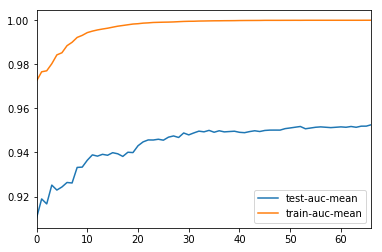

In [46]:
ml.choose_best_n_estimators()

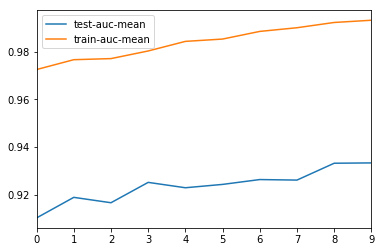

In [36]:
cv_mean = cvresult.iloc[:,[0,2]]
cv_mean.plot()
plt.show()

In [45]:
ml.mod_list[1]['mod'].get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1}

In [48]:
from sklearn.model_selection import GridSearchCV
cv_params = {'max_depth': [2,3,4,5,6], 'min_child_weight': [1,5]}
clt = ml.mod 

optimized_GBM = GridSearchCV(clt, 
                             cv_params,  
                             cv = 5, verbose=10,
                             n_jobs = 2)
optimized_GBM.fit(ml.X_train, ml.y_train)
#optimized_GBM.grid_scores_
optimized_GBM

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.4s


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1821s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.7s


[Parallel(n_jobs=2)]: Done  33 tasks      | elapsed:    4.3s


[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    4.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=67, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=819, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'max_depth': [2, 3, 4, 5, 6], 'min_child_weight': [1, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [67]:
optimized_GBM.best_params_
#optimized_GBM.best_estimator_

ml.mod_list[1]['mod']

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [64]:
optimized_GBM.cv_results_

{'mean_fit_time': array([ 22.13940001,  19.81980009,  27.28840003,  26.69040003,
         31.84960003,  33.41399999,  40.33579998,  39.01080003,
         46.83200006,  48.64400001]),
 'mean_score_time': array([ 0.0566    ,  0.04359989,  0.04319997,  0.04139996,  0.03980002,
         0.05380006,  0.05660005,  0.04879999,  0.05159998,  0.05079999]),
 'mean_test_score': array([ 0.49864456,  0.52326292,  0.44414339,  0.48678984,  0.41074115,
         0.46114118,  0.37334339,  0.43046364,  0.27229416,  0.42463209]),
 'mean_train_score': array([ 0.60930927,  0.60262171,  0.65474553,  0.63972517,  0.70270241,
         0.6786426 ,  0.74995286,  0.71821972,  0.79545233,  0.75475748]),
 'param_max_depth': masked_array(data = [2 2 3 3 4 4 5 5 6 6],
              mask = [False False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 5 1 5 1 5 1 5 1 5],
              mask = [False False False False False False False False Fal

In [65]:
print("Grid scores on development set:")
print()
means = optimized_GBM.cv_results_['mean_test_score']
stds = optimized_GBM.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, optimized_GBM.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Grid scores on development set:
()
0.499 (+/-0.182) for {'max_depth': 2, 'min_child_weight': 1}
0.523 (+/-0.194) for {'max_depth': 2, 'min_child_weight': 5}
0.444 (+/-0.236) for {'max_depth': 3, 'min_child_weight': 1}
0.487 (+/-0.280) for {'max_depth': 3, 'min_child_weight': 5}
0.411 (+/-0.298) for {'max_depth': 4, 'min_child_weight': 1}
0.461 (+/-0.348) for {'max_depth': 4, 'min_child_weight': 5}
0.373 (+/-0.402) for {'max_depth': 5, 'min_child_weight': 1}
0.430 (+/-0.444) for {'max_depth': 5, 'min_child_weight': 5}
0.272 (+/-0.770) for {'max_depth': 6, 'min_child_weight': 1}
0.425 (+/-0.451) for {'max_depth': 6, 'min_child_weight': 5}
()


In [132]:
feat_names = ml.X_train.columns.values
importances = ml.mod_list[0]['mod'].feature_importances_
indices = np.argsort(importances)
indices[:20].tolist()
ml.X_train.columns.values[indices[:20].tolist()]

sort_list = sorted(zip(map(lambda x: round(x, 4), importances), feat_names), reverse=True)
sort_list[:20]

[(0.5982, 'X314'),
 (0.1099, 'X315'),
 (0.044, 'X118'),
 (0.0409, 'X263'),
 (0.0398, 'X119'),
 (0.0196, 'X136'),
 (0.0194, 'ID'),
 (0.015, 'X29'),
 (0.014, 'X127'),
 (0.0121, 'X279'),
 (0.0091, 'X189'),
 (0.0068, 'X76'),
 (0.0068, 'X5_ag'),
 (0.0061, 'X232'),
 (0.0047, 'X54'),
 (0.0034, 'X1_f'),
 (0.0032, 'X5_q'),
 (0.0022, 'X6_c'),
 (0.002, 'X6_k'),
 (0.0015, 'X345')]

In [90]:
ml.mod_list

[{'mod': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, n_jobs=1, oob_score=False, random_state=43,
             verbose=0, warm_start=False), 'name': 'RFR'}]

In [47]:
ml.all_df.describe()
ml.all_df.get_dtype_counts()

float64      1
int64      128
object       7
dtype: int64

In [28]:
ml.test_df.describe()

,ID,X10,X11,X12,X13,X14,X15,X16,X17,X18,...,X377,X378,X379,X380,X382,X383,X384,X385,y,col_is_train
count,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.0,4209.0
mean,4211.039202,0.019007,0.000238,0.074364,0.061060,0.427893,0.000713,0.002613,0.008791,0.010216,...,0.311951,0.019244,0.011879,0.008078,0.008791,0.000475,0.000713,0.001663,0.0,0.0
std,2423.078926,0.136565,0.015414,0.262394,0.239468,0.494832,0.026691,0.051061,0.093357,0.100570,...,0.463345,0.137399,0.108356,0.089524,0.093357,0.021796,0.026691,0.040752,0.0,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,2115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,4202.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,6310.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,8416.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0
